<a href="https://colab.research.google.com/github/s-r-aman/machine_learning_playground/blob/master/fastdoai_dl/lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_009690.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02460.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01950.png')]

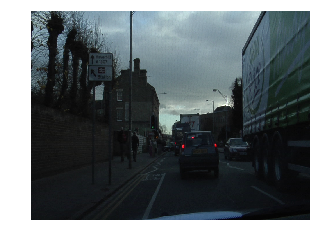

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

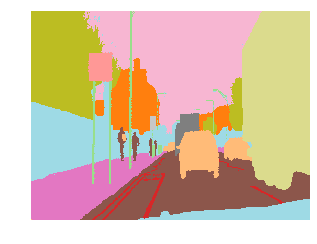

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 27, 27, 27],
          [26, 26, 26,  ..., 27, 27, 27],
          [26, 26, 26,  ..., 27, 27, 27],
          ...,
          [ 5,  5,  5,  ..., 30, 30, 30],
          [ 5,  5,  5,  ..., 30, 30, 30],
          [ 5,  5,  5,  ..., 30, 30, 30]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
if free > 8200: bs=8
else: bs = 4
  
print(f'using bs={bs}, have {free}MB of is GPU free')

using bs=8, have 11430MB of is GPU free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

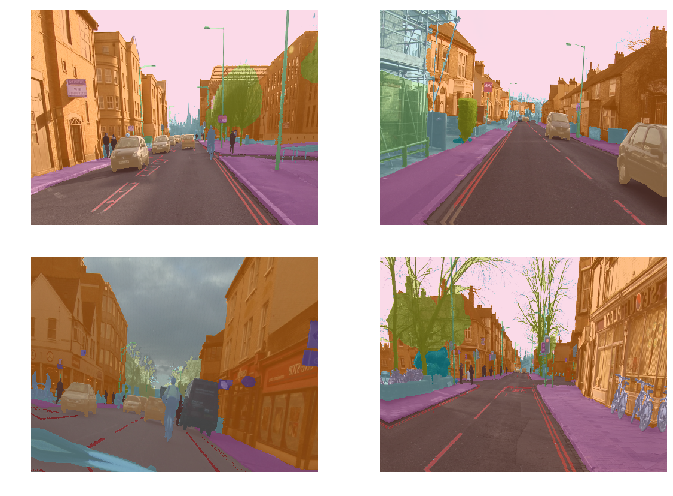

In [14]:
data.show_batch(2, figsize=(10,7))

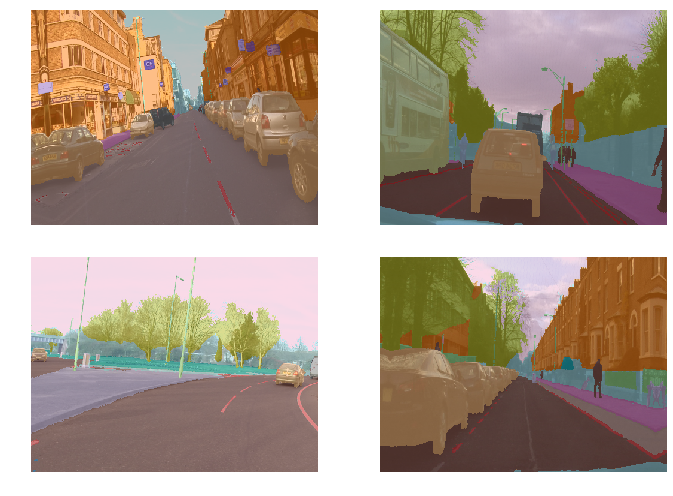

In [15]:
data.show_batch(2, figsize=(10,7), d_type=DatasetType.Valid)

In [0]:
name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
wd = 1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 83714750.30it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


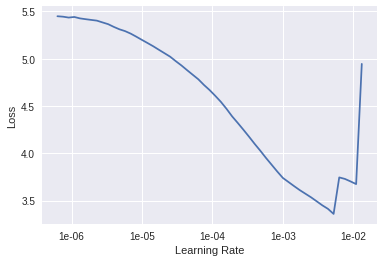

In [21]:
lr_find(learn)
learn.recorder.plot()